# Autoencoder for Super Resolution on Fashion MNIST

This AutoEncoder (AE) will try to remove the random noise on the pictures of clothings.<br>
The input data is the famous Fahsion MNIST with thousands of 28x28 pictures. <br>
Gaussian noise was added on the input data. <br>
The target images are the original images from the dataset.<br>
The input to the AE are the pictures that with additional noise.

## Import Modules

In [26]:
# visualization of images and analytic cruves
import matplotlib.pyplot as plt
# analytics
import numpy as np
# dl framework
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
# accelerated dl framework
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar

## Download Data and Transform

In [27]:
# download full dataset for trainin and validation
mnist_dataset = torchvision.datasets.FashionMNIST(root="",
                                                  transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,), (0.5,))]),
                                                  train=True,
                                                  download=True)

# split the entire dataset into validation and training set
mnist_train_dataset, mnist_val_dataset = random_split(dataset=mnist_dataset, 
                                                      lengths=[int(len(mnist_dataset)*0.9), 
                                                               int(len(mnist_dataset)*0.1)])

# download the test data
mnist_test_dataset = torchvision.datasets.FashionMNIST(root="",
                                                  transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,), (0.5,))]),
                                                  train=False,
                                                  download=True)

54000 6000


In [28]:
batch_size = 64
shuffle = True
# train dataloader
mnist_train_dataloader = DataLoader(mnist_train_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

# val dataloader
mnist_val_dataloader = DataLoader(mnist_val_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

# test dataloader
mnist_test_dataloader = DataLoader(mnist_test_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle)

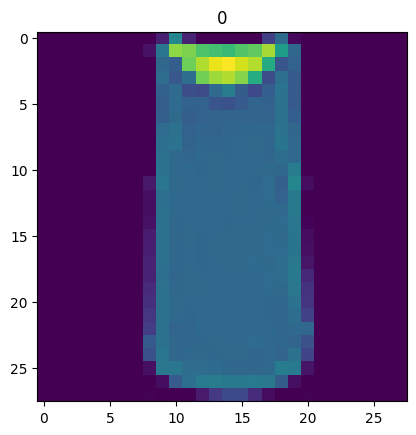

In [29]:
# plot image dependent on the index in the dataset
def visualize_picture(index: int) -> None:
    img = np.array(mnist_dataset[index][0]).reshape(28, 28)
    label = mnist_dataset[index][1]
    plt.imshow(img)
    plt.title(label)

# example of mnist image
visualize_picture(2)

## Define AutoEncoder

In [30]:
# autoencoder in class structure
class SRAE(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # loss criterion
        self.criterion = nn.MSELoss()

        # encoding procedure
        self.encode = nn.Sequential(
             nn.Linear(784, 100),
             nn.PReLU(),
             nn.Linear(100, 10),
             nn.PReLU())


        # decoding procedure
        self.decode = nn.Sequential(
             nn.Linear(10, 100),
             nn.PReLU(),
             nn.Linear(100,784),
             nn.Sigmoid()
             )


    def forward(self,x):

        # encode input to latent space
        encoded = self.encode(x)
        
        # decode from latent space
        decoded = self.decode(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch
        x = x.view(x.size(0), -1)

        # adding gaussiona noise to the image

        # predicted image from AE 
        x_hat = self(x)


        # using mean squared error to calculate 
        # the distance to the true values
        loss = self.criterion(x_hat, x)

        # log the loss for better visualization
        self.log('train_loss', 
                 loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch
        x = x.view(x.size(0), -1)

        # adding gaussiona noise to the image

        # predicted image from AE 
        x_hat = self(x)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = self.criterion(x_hat, x)

        # log the loss for better visualization
        self.log('val_loss', 
                 loss)
        return loss

    def test_step(self, batch, batch_idx):
        # extract the image from the bact
        x, _ = batch
        x = x.view(x.size(0), -1)

        # adding gaussiona noise to the image

        # predicted image from AE 
        x_hat = self(x)

        # using mean squared error to calculate 
        # the distance to the true values
        loss = self.criterion(x_hat, x)

        # log the loss for better visualization
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        # adam optimizer
        optim = Adam(params= self.parameters(),
                     lr=1e-3)
        return optim

## Train AutoEncoder

In [31]:
model = SRAE()
trainer = Trainer(max_epochs=5,
                  callbacks=[TQDMProgressBar(refresh_rate=5)])
trainer.fit(model=model,
            train_dataloaders=mnist_train_dataloader,
            val_dataloaders=mnist_val_dataset)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/leonrenn/opt/miniconda3/envs/TorchExample/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1791: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | encode    | Sequential | 7.9 K 
2 | decode    | Sequential | 8.6 K 
-----------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/leonrenn/opt/miniconda3/envs/TorchExample/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## Performance on Test

In [32]:
trainer.test(model=model,
             dataloaders=mnist_test_dataloader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.10144776105880737
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10144776105880737}]

## Summary